# <b>Assignment 3: RNNs for stock price prediction</b>


In [56]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

In [57]:
!pip install plotly

In [58]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import yfinance as yf
import tensorflow as tf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go
import warnings
import optuna

from matplotlib.patches import Rectangle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError

In [59]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Helper function

In [60]:
def plot_mse_comparison(models_histories, model_names):
    fig, axs = plt.subplots(len(models_histories), 1, figsize=(12, len(models_histories) * 4))
    
    for i, (history, name) in enumerate(zip(models_histories, model_names)):
        axs[i].plot(history.history['mse'], label='Train MSE', color='blue', marker='o')
        axs[i].plot(history.history['val_mse'], label='Validation MSE', color='orange', marker='h')
        axs[i].set_title(f'MSE Comparison for {name}')
        axs[i].set_ylabel('MSE')
        axs[i].set_xlabel('Epoch')
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_grouped_predictions(predictions_list, indices, data_source, y_test, titles):
    num_plots = len(predictions_list)  # Number of models to plot
    fig, axs = plt.subplots(2, num_plots, figsize=(num_plots * 6, 16), sharey='row')
    # Adjust spacing between rows and columns
    plt.subplots_adjust(hspace=5.8, wspace=0.3)
    
    test_range = len(data_source) - len(y_test)
    
    for i, (predictions, idx, title) in enumerate(zip(predictions_list, indices, titles)):
        # Main plot (first row)
        ax_main = axs[0, i]
        ax_main.set_title(title, fontsize=28, pad=50)  # Add padding to the title
        ax_main.set_xlabel('Date', fontsize=18)
        if i == 0:  # Only the first column has a y-label
            ax_main.set_ylabel('Closing Price', fontsize=20)
        
        # Plot actual and predicted values
        ax_main.plot(data_source.iloc[:test_range, idx], label='Train Data', color='blue')
        ax_main.plot(data_source.iloc[test_range:, idx], label='Test Data', color='orange')
        ax_main.plot(data_source[test_range:].index, predictions[:, idx], label='Prediction', color='green')
        
        # Add a rectangle to highlight prediction area
        window_start = data_source[test_range:].index[0]
        window_end = data_source[test_range:].index[-1]
        width = window_end - window_start
        height = max(predictions[:, idx]) - min(predictions[:, idx]) + 30
        rectangle = Rectangle(
            (window_start, min(predictions[:, idx]) - 10),
            width,
            height,
            fill=False,
            edgecolor='red',
            linestyle='dashed'
        )
        ax_main.add_patch(rectangle)
        ax_main.legend(loc='lower right', fontsize=16)
        ax_main.grid(True)

        # Add some vertical spacing
        axs[1, i].set_position([axs[1, i].get_position().x0,
                                axs[1, i].get_position().y0 + 0.1,
                                axs[1, i].get_position().width,
                                axs[1, i].get_position().height])
        
        # Magnified plot (second row)
        ax_zoom = axs[1, i]
        ax_zoom.plot(data_source.iloc[test_range:, idx], color='orange', label='Test Data')
        ax_zoom.plot(data_source[test_range:].index, predictions[:, idx], color='green', label='Prediction')
        ax_zoom.set_xlim(window_start, window_end)
        ax_zoom.set_ylim(min(predictions[:, idx]) - 10, max(predictions[:, idx]) + 10)
        ax_zoom.set_title(f'{title} (Magnified)', fontsize=28, pad=50)  # Add padding to the magnified view title
        ax_zoom.set_xlabel('Date', fontsize=18)
        if i == 0:  # Only the first column has a y-label
            ax_zoom.set_ylabel('Closing Price', fontsize=20)
        ax_zoom.legend(loc='lower right', fontsize=16)
        ax_zoom.grid(True)
    plt.tight_layout()
    plt.show()

## <b>1: Exploratory Data Analysis (EDA)</b>

In [61]:
# Display Google's stock price data
ticker = yf.Ticker('GOOG')

start_date = '2012-01-03'

dataset = ticker.history(start=start_date, end=None)

dataset.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.222704,16.600606,16.208540,16.532528,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.523088,16.652782,16.413519,16.603836,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.451035,16.496751,16.304445,16.373516,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.376995,16.398115,16.144440,16.150156,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0


In [62]:
# Define the candlestick chart trace using the stock data
candlestick_trace = go.Candlestick(
    x=dataset.index,
    open=dataset['Open'],
    high=dataset['High'],
    low=dataset['Low'],
    close=dataset['Close'],
    name='Candlestick'
)

# Define the layout of the chart
chartLayout = go.Layout(
    title='Google Stock Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Combine the candlestick trace and layout into a figure object
fig = go.Figure(data=[candlestick_trace], layout=chartLayout)

# Disable the range slider for the x-axis in the figure layout
fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()

In [63]:
# Reorder the 'Close' column to the first position
dataset = dataset[['Close'] + [col for col in dataset.columns if col != 'Close']]
dataset.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,16.532528,16.222704,16.600606,16.208540,147611217,0.0,0.0
2012-01-04 00:00:00-05:00,16.603836,16.523088,16.652782,16.413519,114989399,0.0,0.0
2012-01-05 00:00:00-05:00,16.373516,16.451035,16.496751,16.304445,131808205,0.0,0.0
2012-01-06 00:00:00-05:00,16.150156,16.376995,16.398115,16.144440,108119746,0.0,0.0
2012-01-09 00:00:00-05:00,15.465409,16.062697,16.075122,15.434848,233776981,0.0,0.0


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3253 entries, 2012-01-03 00:00:00-05:00 to 2024-12-05 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3253 non-null   float64
 1   Open          3253 non-null   float64
 2   High          3253 non-null   float64
 3   Low           3253 non-null   float64
 4   Volume        3253 non-null   int64  
 5   Dividends     3253 non-null   float64
 6   Stock Splits  3253 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 203.3 KB


In [65]:
dataset.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [66]:
dataset.duplicated().sum()

0

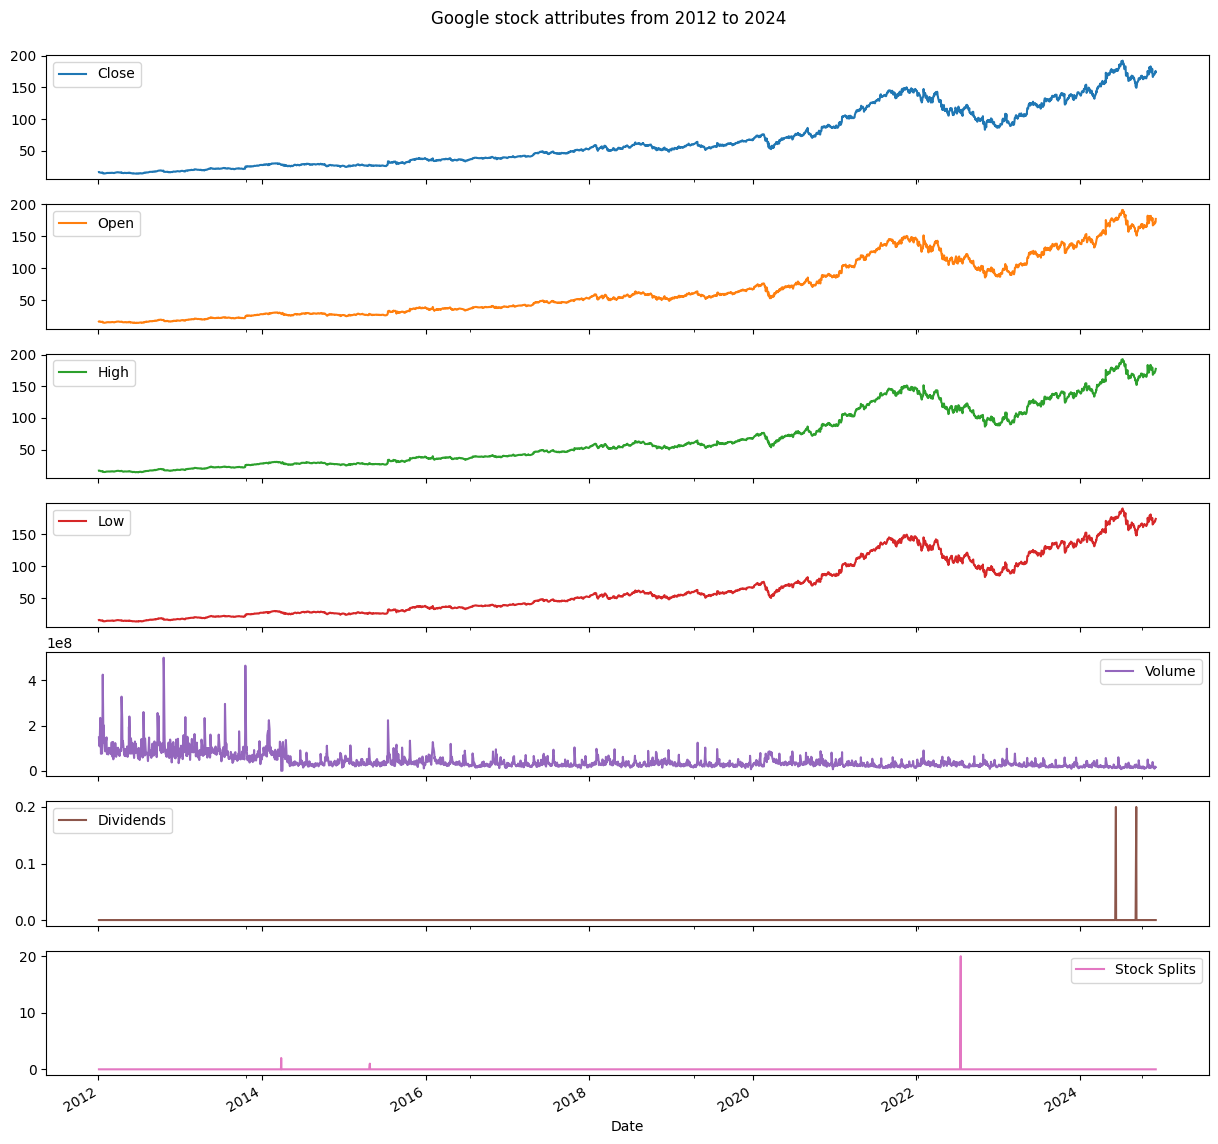

In [67]:
dataset.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google stock attributes from 2012 to 2024', y=0.91)
plt.show()

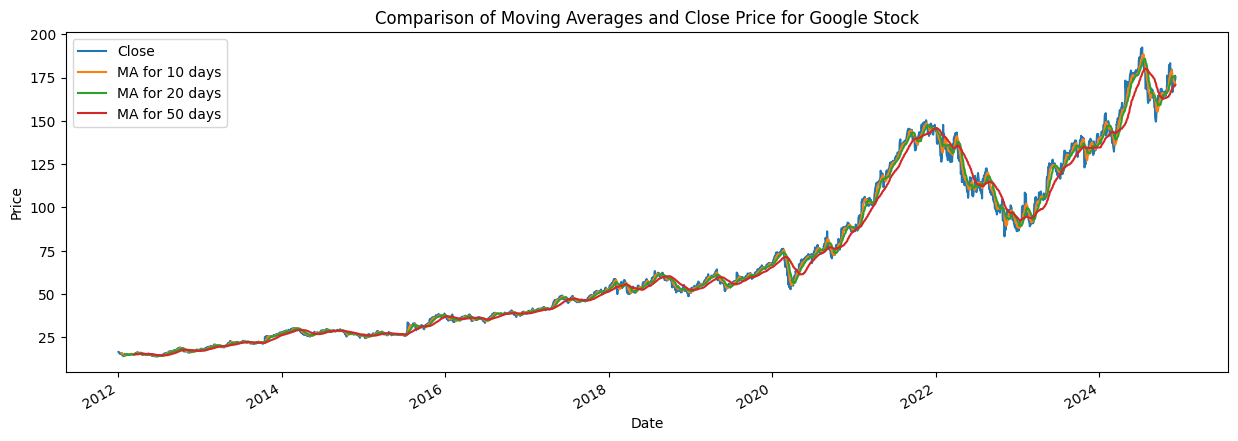

In [68]:
# Define moving average windows
ma_day = [10, 20, 50]

# Compute moving averages using a dictionary for flexibility
ma_columns = {f'MA for {ma} days': dataset['Close'].rolling(window=ma).mean() for ma in ma_day}

# Add the computed MAs to the dataset
dataset = dataset.assign(**ma_columns)

# Plot Close price and moving averages
columns_to_plot = ['Close'] + list(ma_columns.keys())
dataset[columns_to_plot].plot(figsize=(15, 5))

plt.title('Comparison of Moving Averages and Close Price for Google Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

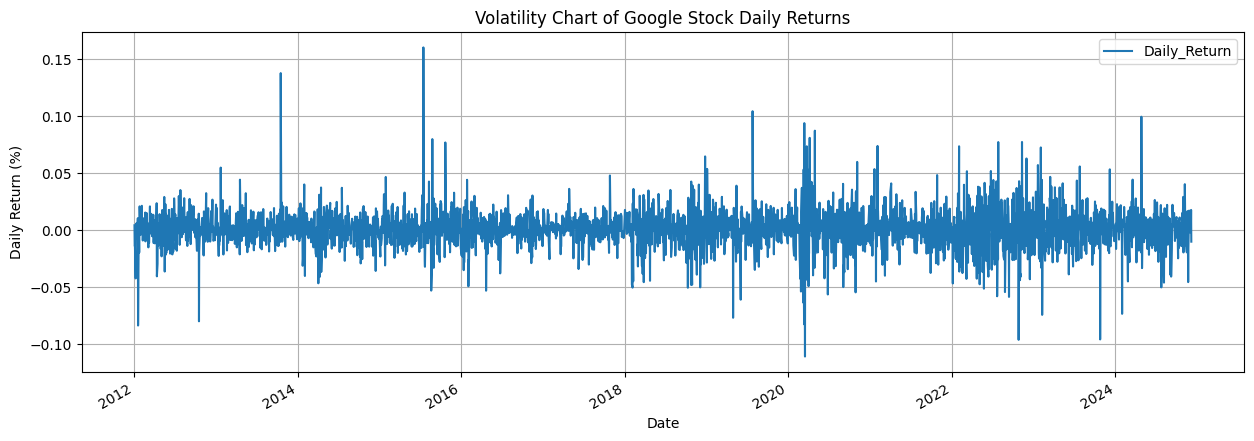

In [69]:
# Compute daily return percentage
dataset = dataset.assign(Daily_Return=lambda x: x['Close'].pct_change())

# Plot daily return
dataset['Daily_Return'].plot(figsize=(15, 5), legend=True)

# Add plot title and labels
plt.title('Volatility Chart of Google Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.show()

## <b>2. Data Pre-processing</b>

In [70]:
# Data Normalization
dataset_clone = dataset.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0, 15))

# Apply the scaler to all relevant columns at once
columns_to_scale = ['Open', 'High', 'Low', 'Close']
dataset_clone[columns_to_scale] = scaler.fit_transform(dataset_clone[columns_to_scale])

# Extract the scaled data as a NumPy array
data = dataset_clone[columns_to_scale].values
data.shape

(3253, 4)

In [71]:
# Preparing Data for Time Series
sequence_length = 11
sequences = []
for index in range(len(data) - sequence_length + 1): 
    sequences.append(data[index: index + sequence_length])
sequences = np.array(sequences)

In [72]:
# Define percentages for validation and test sets
valid_set_size_percentage = 10
test_set_size_percentage = 10

# Calculate the test size ratio
test_ratio = test_set_size_percentage / 100
valid_ratio = valid_set_size_percentage / (100 - test_set_size_percentage)  # Adjust for remaining data after test split

# First, split off the test set
train_valid_sequences, x_test, train_valid_targets, y_test = train_test_split(
    sequences[:, :-1, :], sequences[:, -1, :], test_size=test_ratio, random_state=42, shuffle=False
)

# Then, split the remaining data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    train_valid_sequences, train_valid_targets, test_size=valid_ratio, random_state=42, shuffle=False
)

## <b>3. Predicting models</b>

### 3.1 Vanilla RNN

In [73]:
vanilla_rnn = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

vanilla_rnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954 (11.54 KB)

 Trainable params: 2,954 (11.54 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
vanilla_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [75]:
vanilla_rnn_hist = vanilla_rnn.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 12.4627 - mse: 12.4627 - val_loss: 17.3008 - val_mse: 17.3008
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0824 - mse: 4.0824 - val_loss: 7.4354 - val_mse: 7.4354
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0631 - mse: 2.0631 - val_loss: 3.5506 - val_mse: 3.5506
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4390 - mse: 1.4390 - val_loss: 1.5248 - val_mse: 1.5248
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7660 - mse: 0.7660 - val_loss: 0.6675 - val_mse: 0.6675
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4428 - mse: 0.4428 - val_loss: 0.3162 - val_mse: 0.3162
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3309 - mse: 0.3309 - val_loss: 0.1655 - val_mse: 0.1655
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1719 - mse: 0.1719 - val_loss: 0.1412 - val_mse: 0.1412
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1385 - 

In [76]:
# Make predictions
predictions_vanilla_rnn = vanilla_rnn.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, predictions_vanilla_rnn)
print(f'MSE of Model Vanilla RNN: {mse:.3f}')

# Rescale predictions back to the original scale
predictions_vanilla_rnn = scaler.inverse_transform(predictions_vanilla_rnn)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MSE of Model Vanilla RNN: 1.776


### 3.2 Stacked LSTM

In [77]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length-1, 4)))
stacked_lstm.add(LSTM(units=50))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(units=4))

stacked_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,404 (122.67 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
stacked_lstm.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [79]:
stacked_lstm_hist = stacked_lstm.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.4481 - mse: 12.4481 - val_loss: 15.9101 - val_mse: 15.9101
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4184 - mse: 3.4184 - val_loss: 3.4894 - val_mse: 3.4894
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.3036 - mse: 1.3036 - val_loss: 0.7931 - val_mse: 0.7931
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7170 - mse: 0.7170 - val_loss: 0.2860 - val_mse: 0.2860
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4423 - mse: 0.4423 - val_loss: 0.4050 - val_mse: 0.4050
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3039 - mse: 0.3039 - val_loss: 0.1346 - val_mse: 0.1346
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2563 - mse: 0.2563 - val_loss: 0.1567 - val_mse: 0.1567
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2218 - mse: 0.2218 - val_loss: 0.1303 - val_mse: 0.1303
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0

In [80]:
# Make predictions
prediction_stacked_lstm = stacked_lstm.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, prediction_stacked_lstm)
print(f'MSE of Model Stacked LSTM: {mse:.3f}')

# Rescale predictions back to the original scale
prediction_stacked_lstm = scaler.inverse_transform(prediction_stacked_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
MSE of Model Stacked LSTM: 1.003


### 3.3 Gated Recurrent Unit (GRU)

In [81]:
gru = Sequential([
    GRU(50, return_sequences=False, input_shape=(sequence_length-1, 4)),
    Dense(4)
])

gru.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 50)             │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,604 (33.61 KB)

 Trainable params: 8,604 (33.61 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Compile model
gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [83]:
# Train model
gru_hist = gru.fit(x_train, 
                   y_train, 
                   epochs=50, 
                   batch_size=64, 
                   validation_data=(x_valid, y_valid))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 13.1277 - mse: 13.1277 - val_loss: 18.4397 - val_mse: 18.4397
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9498 - mse: 3.9498 - val_loss: 8.7466 - val_mse: 8.7466
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4696 - mse: 2.4696 - val_loss: 3.7224 - val_mse: 3.7224
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4858 - mse: 1.4858 - val_loss: 1.4326 - val_mse: 1.4326
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7158 - mse: 0.7158 - val_loss: 0.5751 - val_mse: 0.5751
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4211 - mse: 0.4211 - val_loss: 0.2428 - val_mse: 0.2428
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2327 - mse: 0.2327 - val_loss: 0.1348 - val_mse: 0.1348
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1562 - mse: 0.1562 - val_loss: 0.0886 - val_mse: 0.0886
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0883 - 

In [84]:
prediction_gru = gru.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_gru)
print(f'MSE of GRU: {mse:.3f}')

prediction_gru = scaler.inverse_transform(prediction_gru)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE of GRU: 1.866


In [85]:
# Save the entire model to a HDF5 file.
stacked_lstm.save('/kaggle/working/stacked_lstm_model.h5')

### 3.4 Hyperparameter tuning (Stacked LSTM)

In [86]:
# Load the model with custom_objects
final_model = load_model(
    '/kaggle/working/stacked_lstm_model.h5',
    custom_objects={'mse': MeanSquaredError()}
)

# Verify the model
final_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,406 (122.68 KB)

 Trainable params: 31,404 (122.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [87]:
def objective(trial, model):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 30, 100)
    
    # Clone the model to avoid modifying the original
    tuning_model = tf.keras.models.clone_model(model)
    tuning_model.set_weights(model.get_weights())
    
    # Recompile the model with tuned learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tuning_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    # Train the model with tuned hyperparameters
    hyper_history = tuning_model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    # Predict and calculate validation loss
    predictions = tuning_model.predict(x_valid)
    val_loss = mean_squared_error(y_valid, predictions)
    
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, final_model), n_trials=50)

# Print best trial details
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value (validation loss):', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Retrain the model with best hyperparameters
best_model = tf.keras.models.clone_model(final_model)
best_model.set_weights(stacked_lstm.get_weights())
best_optimizer = tf.keras.optimizers.Adam(learning_rate=trial.params['learning_rate'])
best_model.compile(optimizer=best_optimizer, loss='mse', metrics=['mse'])

# Fit with best hyperparameters
best_model.fit(
    x_train,
    y_train,
    epochs=trial.params['epochs'],
    batch_size=trial.params['batch_size'],
    validation_data=(x_valid, y_valid)
)

# Predict and calculate MSE on test set
prediction_best_lstm = best_model.predict(x_test)
prediction_best_lstm = scaler.inverse_transform(prediction_best_lstm)

# Save the best model
best_model.save('best_stacked_lstm.h5')

[I 2024-12-06 07:45:16,712] A new study created in memory with name: no-name-3d844c40-c738-4238-9af0-eaf683271b17


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:45:51,678] Trial 0 finished with value: 0.03837767354291217 and parameters: {'learning_rate': 0.009199576211500506, 'batch_size': 128, 'epochs': 71}. Best is trial 0 with value: 0.03837767354291217.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:47:22,338] Trial 1 finished with value: 0.035227991870308006 and parameters: {'learning_rate': 0.004811526094989398, 'batch_size': 32, 'epochs': 98}. Best is trial 1 with value: 0.035227991870308006.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:48:23,868] Trial 2 finished with value: 0.04569437422985435 and parameters: {'learning_rate': 0.0001973234759937851, 'batch_size': 32, 'epochs': 65}. Best is trial 1 with value: 0.035227991870308006.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:48:59,810] Trial 3 finished with value: 0.06137023784246716 and parameters: {'learning_rate': 0.0041894400515513925, 'batch_size': 128, 'epochs': 74}. Best is trial 1 with value: 0.035227991870308006.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:49:36,040] Trial 4 finished with value: 0.030955135435773377 and parameters: {'learning_rate': 0.00021616889676987657, 'batch_size': 64, 'epochs': 60}. Best is trial 4 with value: 0.030955135435773377.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:50:21,020] Trial 5 finished with value: 0.046945771279372175 and parameters: {'learning_rate': 0.003539469419533379, 'batch_size': 128, 'epochs': 94}. Best is trial 4 with value: 0.030955135435773377.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:51:02,640] Trial 6 finished with value: 0.035080403113565306 and parameters: {'learning_rate': 0.0034262490724113913, 'batch_size': 128, 'epochs': 86}. Best is trial 4 with value: 0.030955135435773377.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:51:53,914] Trial 7 finished with value: 0.030764840446135984 and parameters: {'learning_rate': 0.0005931012279855902, 'batch_size': 64, 'epochs': 86}. Best is trial 7 with value: 0.030764840446135984.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-06 07:52:25,239] Trial 8 finished with value: 0.03473578561560902 and parameters: {'learning_rate': 0.004231492694925247, 'batch_size': 128, 'epochs': 62}. Best is trial 7 with value: 0.030764840446135984.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:53:01,650] Trial 9 finished with value: 0.036136420915623864 and parameters: {'learning_rate': 0.00010665104131650117, 'batch_size': 128, 'epochs': 75}. Best is trial 7 with value: 0.030764840446135984.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:53:31,595] Trial 10 finished with value: 0.05857716814282832 and parameters: {'learning_rate': 0.0009275598190736546, 'batch_size': 64, 'epochs': 47}. Best is trial 7 with value: 0.030764840446135984.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 07:54:05,187] Trial 11 finished with value: 0.038783865188042 and parameters: {'learning_rate': 0.00046930041290124544, 'batch_size': 64, 'epochs': 46}. Best is trial 7 with value: 0.030764840446135984.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:54:38,319] Trial 12 finished with value: 0.029568381088915525 and parameters: {'learning_rate': 0.00037663731781093255, 'batch_size': 64, 'epochs': 53}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:54:59,813] Trial 13 finished with value: 0.07237427896510372 and parameters: {'learning_rate': 0.0008250754781338415, 'batch_size': 64, 'epochs': 32}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:55:30,879] Trial 14 finished with value: 0.032637867890687365 and parameters: {'learning_rate': 0.00044693471364606955, 'batch_size': 64, 'epochs': 50}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:56:21,068] Trial 15 finished with value: 0.08667941296836815 and parameters: {'learning_rate': 0.001643248510059943, 'batch_size': 64, 'epochs': 85}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:56:54,315] Trial 16 finished with value: 0.194791505256816 and parameters: {'learning_rate': 0.00045143923931296684, 'batch_size': 64, 'epochs': 54}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:57:17,160] Trial 17 finished with value: 0.0870800981346049 and parameters: {'learning_rate': 0.0015994489527589044, 'batch_size': 64, 'epochs': 35}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 07:58:34,669] Trial 18 finished with value: 0.03006726350233576 and parameters: {'learning_rate': 0.00025407956061690494, 'batch_size': 32, 'epochs': 83}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 07:59:14,134] Trial 19 finished with value: 0.0512800746835282 and parameters: {'learning_rate': 0.0002599216460257556, 'batch_size': 32, 'epochs': 40}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


[I 2024-12-06 08:00:29,773] Trial 20 finished with value: 0.03813730595566213 and parameters: {'learning_rate': 0.00010609706960557861, 'batch_size': 32, 'epochs': 81}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:01:54,939] Trial 21 finished with value: 0.033384779362671126 and parameters: {'learning_rate': 0.0006060063785058528, 'batch_size': 32, 'epochs': 91}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:03:27,417] Trial 22 finished with value: 0.03709670985630663 and parameters: {'learning_rate': 0.0002855699190148333, 'batch_size': 32, 'epochs': 100}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


[I 2024-12-06 08:04:15,006] Trial 23 finished with value: 0.04406884694173392 and parameters: {'learning_rate': 0.00016696014844502766, 'batch_size': 64, 'epochs': 81}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:04:49,297] Trial 24 finished with value: 0.029831711569337796 and parameters: {'learning_rate': 0.0003024995094534307, 'batch_size': 64, 'epochs': 56}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


[I 2024-12-06 08:05:42,536] Trial 25 finished with value: 0.07199518394469596 and parameters: {'learning_rate': 0.000344843372440137, 'batch_size': 32, 'epochs': 56}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:06:08,342] Trial 26 finished with value: 0.046043165652504374 and parameters: {'learning_rate': 0.0001434277358250949, 'batch_size': 64, 'epochs': 40}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:07:15,152] Trial 27 finished with value: 0.04608937196289698 and parameters: {'learning_rate': 0.0003228524584693812, 'batch_size': 32, 'epochs': 71}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:07:54,369] Trial 28 finished with value: 0.041976444849995395 and parameters: {'learning_rate': 0.0016599916809928404, 'batch_size': 64, 'epochs': 65}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:09:00,286] Trial 29 finished with value: 0.08875905520333552 and parameters: {'learning_rate': 0.0006475202974833377, 'batch_size': 32, 'epochs': 70}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:09:38,495] Trial 30 finished with value: 0.08238839552798267 and parameters: {'learning_rate': 0.0012377559163023984, 'batch_size': 64, 'epochs': 55}. Best is trial 12 with value: 0.029568381088915525.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:10:26,277] Trial 31 finished with value: 0.029012146408851885 and parameters: {'learning_rate': 0.0006453943241428163, 'batch_size': 64, 'epochs': 78}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:11:11,521] Trial 32 finished with value: 0.03681779362576569 and parameters: {'learning_rate': 0.00036603290275526916, 'batch_size': 64, 'epochs': 75}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:11:48,214] Trial 33 finished with value: 0.030838303659734913 and parameters: {'learning_rate': 0.00019891398143801628, 'batch_size': 64, 'epochs': 59}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:12:35,734] Trial 34 finished with value: 0.07465875753830478 and parameters: {'learning_rate': 0.009524145968087037, 'batch_size': 64, 'epochs': 80}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:13:38,931] Trial 35 finished with value: 0.03771848244618431 and parameters: {'learning_rate': 0.00023294202344189272, 'batch_size': 32, 'epochs': 66}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:14:32,858] Trial 36 finished with value: 0.032544126162917145 and parameters: {'learning_rate': 0.0007576439541819474, 'batch_size': 64, 'epochs': 92}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:15:06,438] Trial 37 finished with value: 0.03888547604567429 and parameters: {'learning_rate': 0.00015365578690080785, 'batch_size': 128, 'epochs': 68}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:15:38,523] Trial 38 finished with value: 0.03160367112294143 and parameters: {'learning_rate': 0.001142249741001213, 'batch_size': 64, 'epochs': 52}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


[I 2024-12-06 08:16:37,626] Trial 39 finished with value: 0.05461458642225979 and parameters: {'learning_rate': 0.006056977437076008, 'batch_size': 32, 'epochs': 62}. Best is trial 31 with value: 0.029012146408851885.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:17:15,216] Trial 40 finished with value: 0.028954866582315462 and parameters: {'learning_rate': 0.0005059644624632871, 'batch_size': 128, 'epochs': 78}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:17:52,766] Trial 41 finished with value: 0.04652587615941901 and parameters: {'learning_rate': 0.00048773063789422954, 'batch_size': 128, 'epochs': 78}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


[I 2024-12-06 08:18:33,471] Trial 42 finished with value: 0.030556394327150703 and parameters: {'learning_rate': 0.00036891456401098687, 'batch_size': 128, 'epochs': 85}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:19:15,320] Trial 43 finished with value: 0.029588279207279918 and parameters: {'learning_rate': 0.0002787790454936698, 'batch_size': 128, 'epochs': 89}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:20:01,578] Trial 44 finished with value: 0.03747369247205806 and parameters: {'learning_rate': 0.0007108287908872388, 'batch_size': 128, 'epochs': 97}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:20:38,436] Trial 45 finished with value: 0.055198943213438226 and parameters: {'learning_rate': 0.000543602588752172, 'batch_size': 128, 'epochs': 76}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:21:03,263] Trial 46 finished with value: 0.03500150771832482 and parameters: {'learning_rate': 0.00040224350313603, 'batch_size': 128, 'epochs': 48}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2024-12-06 08:21:45,309] Trial 47 finished with value: 0.03160942375318892 and parameters: {'learning_rate': 0.00029214402987849306, 'batch_size': 128, 'epochs': 89}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:22:08,151] Trial 48 finished with value: 0.0294058843252678 and parameters: {'learning_rate': 0.0009389578318623695, 'batch_size': 128, 'epochs': 43}. Best is trial 40 with value: 0.028954866582315462.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2024-12-06 08:22:30,389] Trial 49 finished with value: 0.03418161219735121 and parameters: {'learning_rate': 0.0027156786380389086, 'batch_size': 128, 'epochs': 43}. Best is trial 40 with value: 0.028954866582315462.


Number of finished trials: 50
Best trial:
  Value (validation loss): 0.028954866582315462
  Params: 
    learning_rate: 0.0005059644624632871
    batch_size: 128
    epochs: 78
Epoch 1/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1052 - mse: 0.1052 - val_loss: 0.0501 - val_mse: 0.0501
Epoch 2/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1127 - mse: 0.1127 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 3/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1102 - mse: 0.1102 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 4/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1071 - mse: 0.1071 - val_loss: 0.0405 - val_mse: 0.0405
Epoch 5/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1107 - mse: 0.1107 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 6/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1133 - mse: 0.1133 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 7/78
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1159 - mse: 0.1159 - val_loss: 0.0597 - val_mse: 0.0597
Epoc

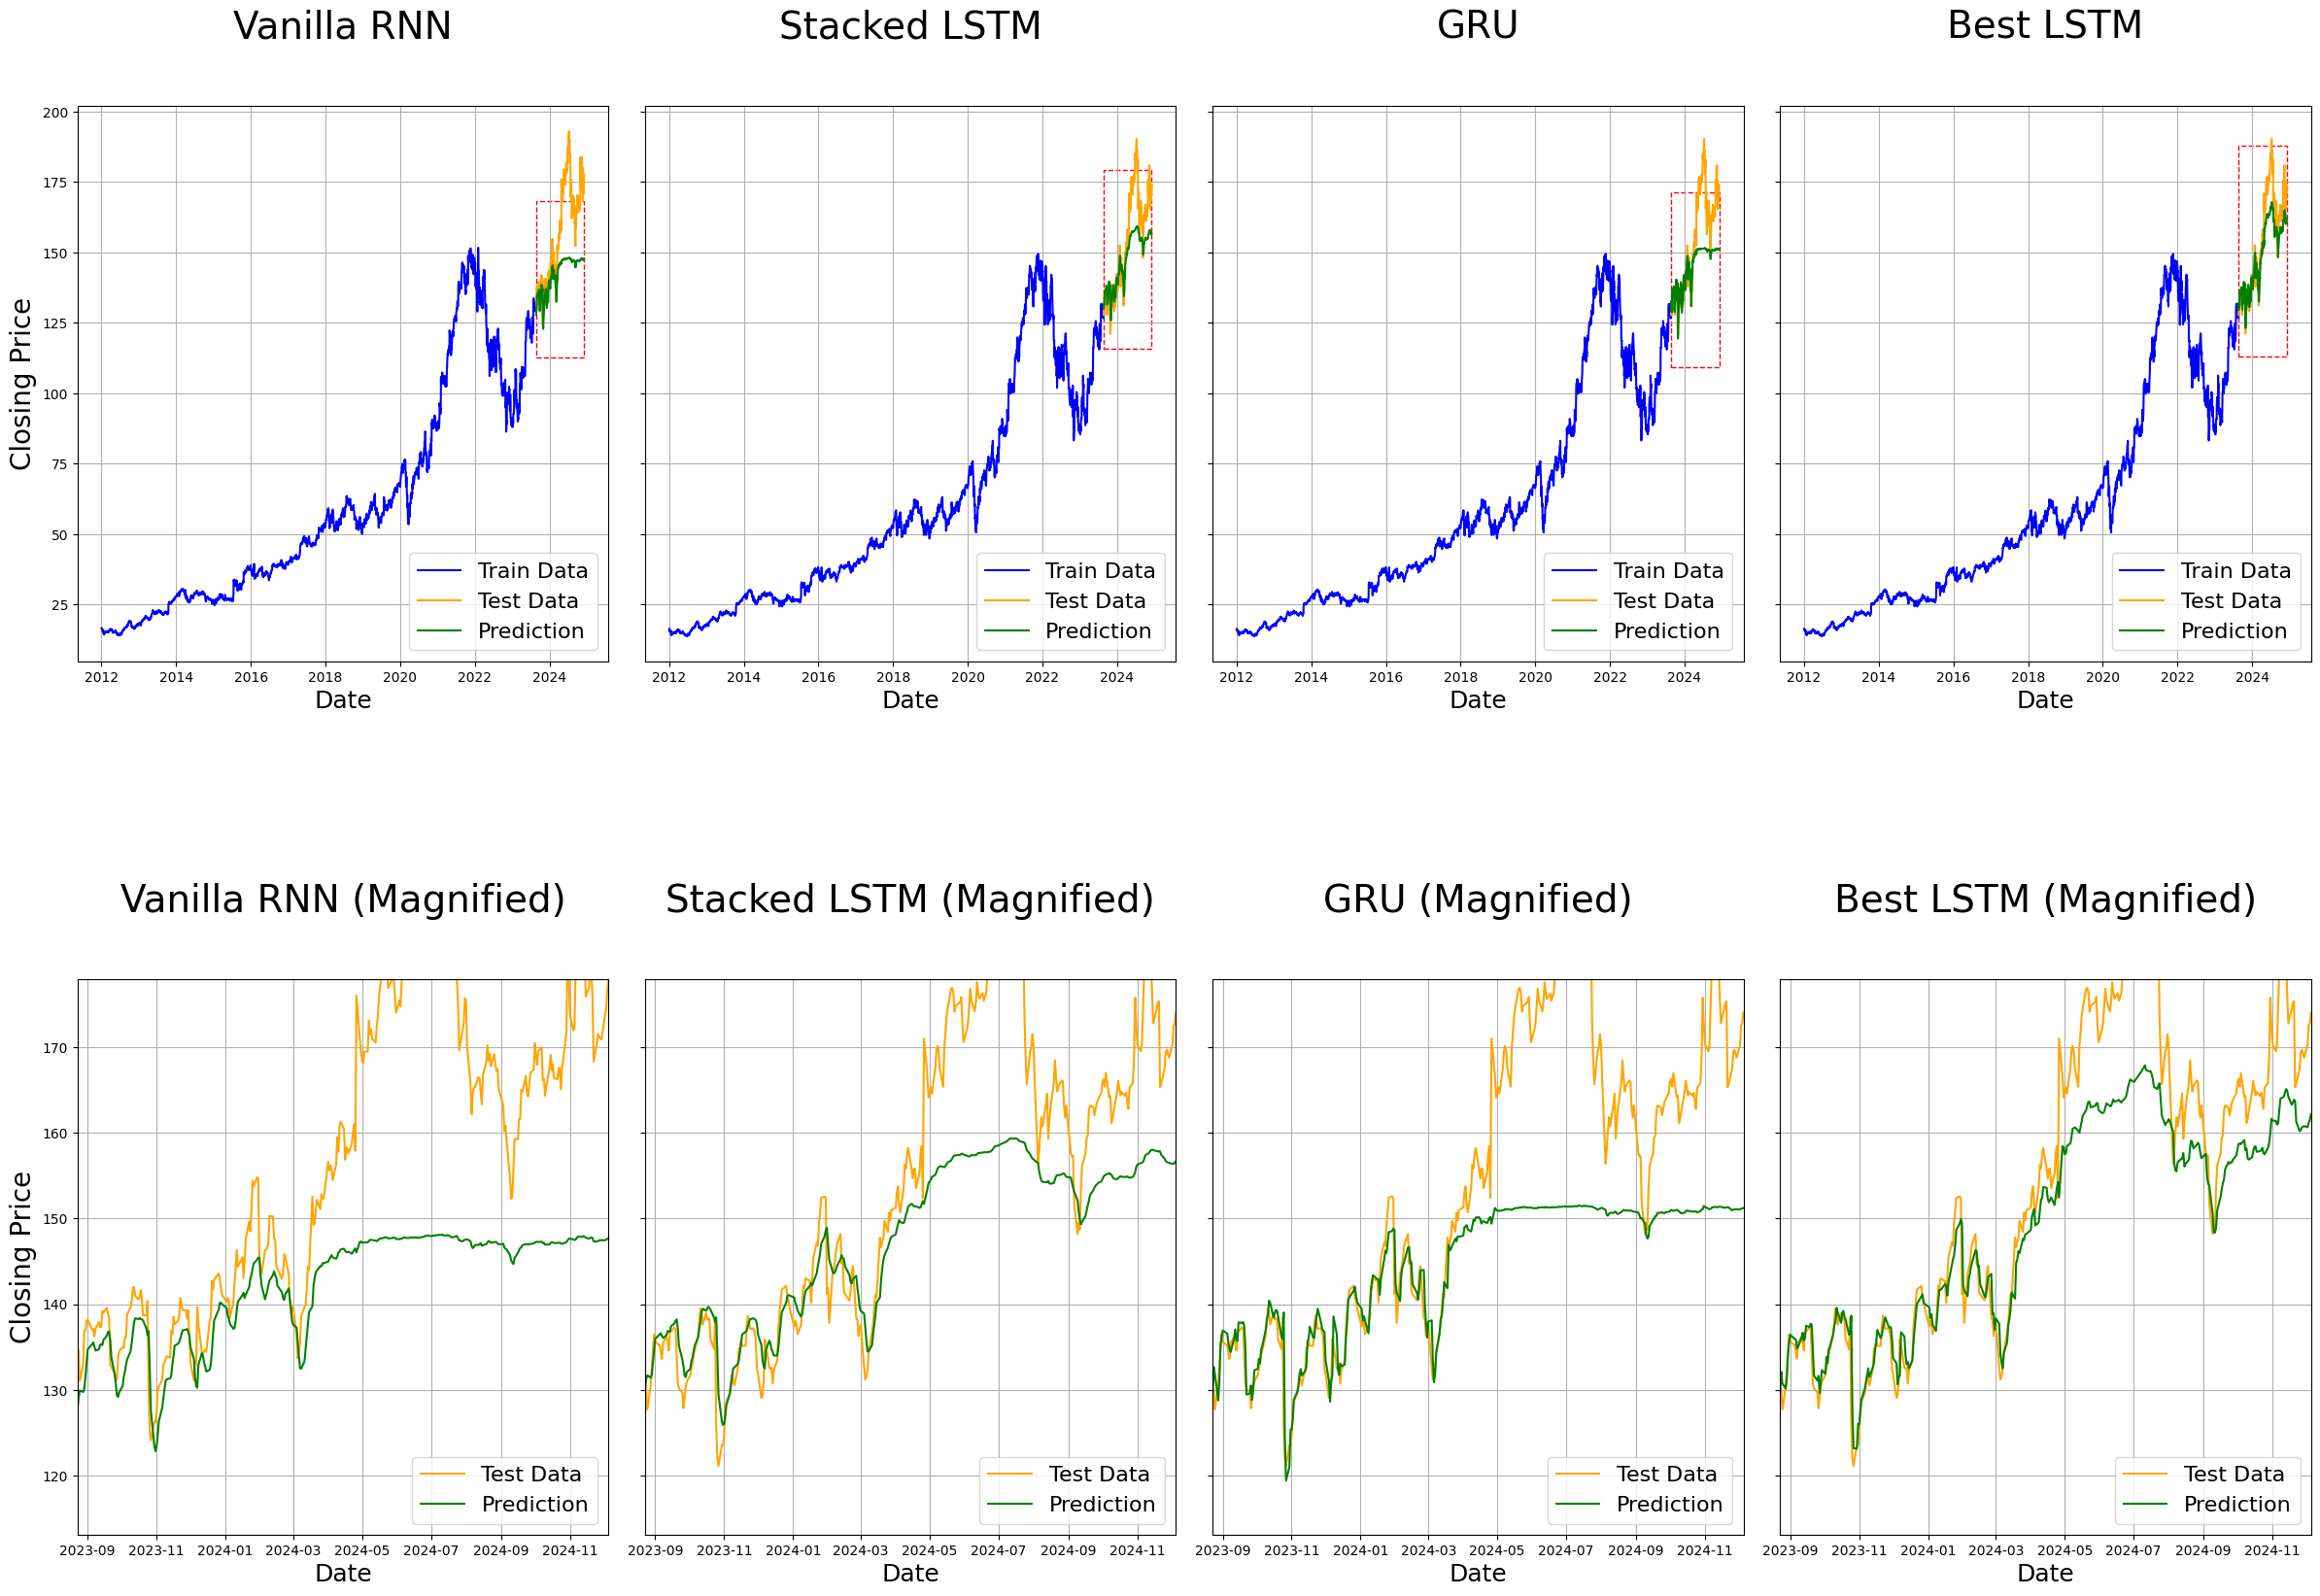

In [88]:
plot_grouped_predictions(
    predictions_list=[predictions_vanilla_rnn, prediction_stacked_lstm, prediction_gru, prediction_best_lstm],
    indices=[2, 3, 3, 3],
    data_source=dataset,
    y_test=y_test,
    titles=['Vanilla RNN', 'Stacked LSTM', 'GRU', 'Best LSTM']
)

### 3.5 Plotting

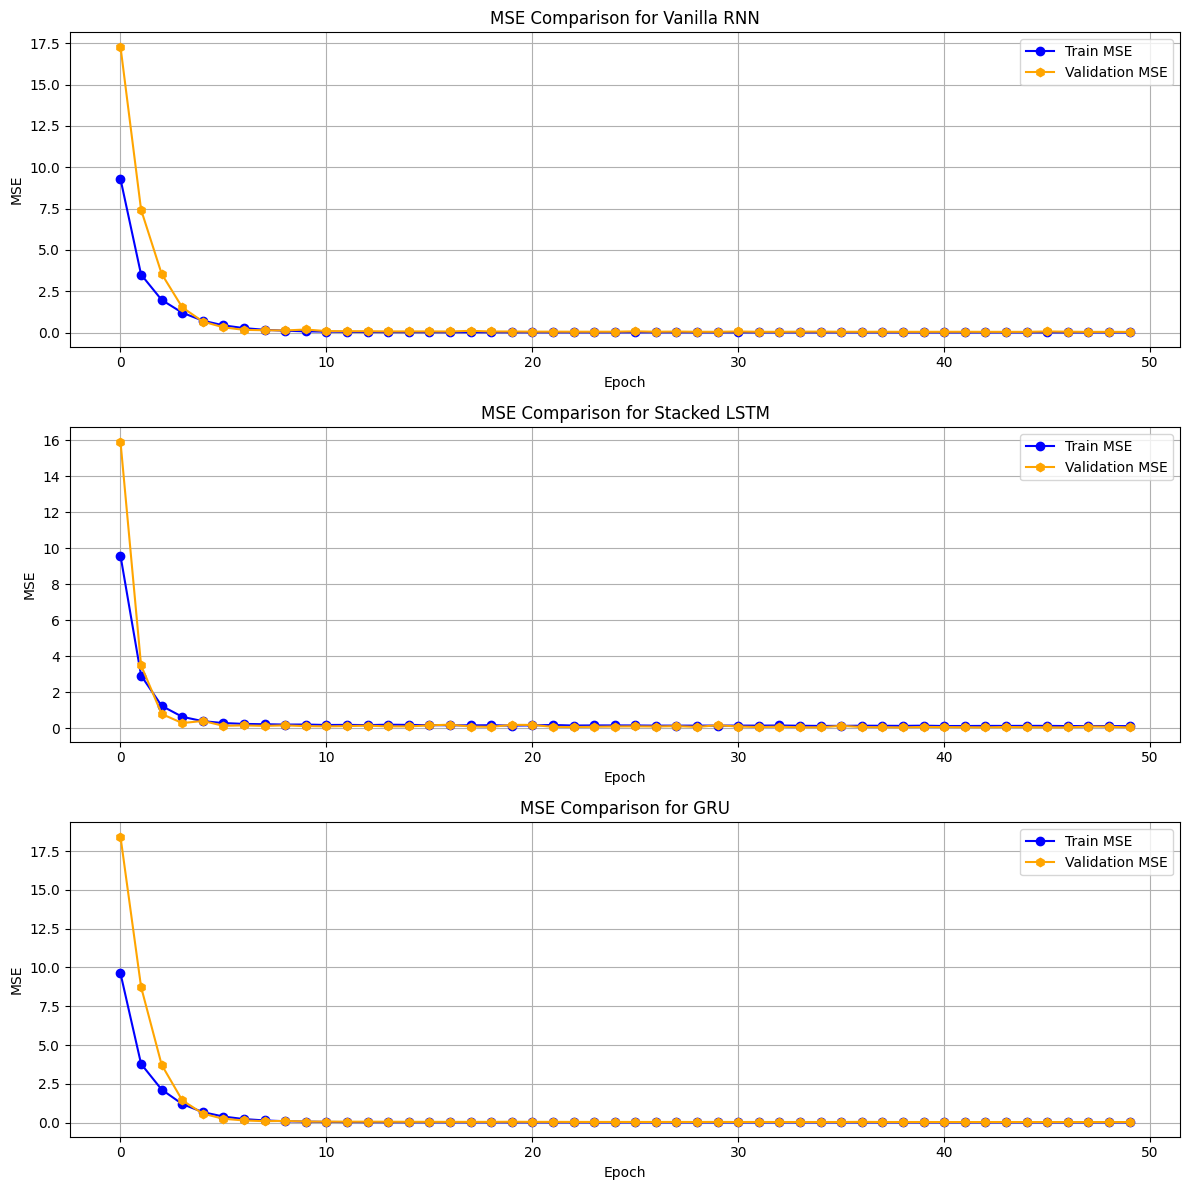

In [89]:
plot_mse_comparison(
    models_histories=[vanilla_rnn_hist, stacked_lstm_hist, gru_hist],
    model_names=['Vanilla RNN', 'Stacked LSTM', 'GRU']
)

## <b>4. Predicting the next 10 days</b>

In [90]:
prediction_best_model = best_model.predict(x_test)
# Calculate MSE
mse = mean_squared_error(y_test, prediction_best_model)
print(f'MSE of Hyperparameter-tuning Stacked LSTM: {mse:.3f}')

prediction_best_model = scaler.inverse_transform(prediction_best_model)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of Hyperparameter-tuning Stacked LSTM: 0.529


In [91]:
# Predict the next 10 days of stock prices

# Extract the last sequence of historical data for prediction
recent_sequence = sequences[-1:, 1:, :]

# Define the number of days to predict
NUM_PREDICTIONS = 10

# Predict stock prices iteratively for the next NUM_PREDICTIONS days
for day in range(NUM_PREDICTIONS):
    # Predict the next time step
    next_prediction = best_model.predict(recent_sequence, verbose=0)
    # Append the prediction to the recent sequence
    recent_sequence = np.concatenate((recent_sequence, next_prediction[np.newaxis, :, :]), axis=1)
    # Remove the oldest time step to maintain sequence length
    recent_sequence = recent_sequence[:, 1:, :]

# Rescale the predictions back to their original values
predicted_prices = scaler.inverse_transform(recent_sequence.reshape(NUM_PREDICTIONS, 4))

# Create a DataFrame to store the predicted stock prices
predicted_df = pd.DataFrame(
    data=predicted_prices, 
    columns=['Open', 'High', 'Low', 'Close']
)

predicted_df

,Open,High,Low,Close
0,162.541672,163.871072,160.556747,162.201740
1,158.673491,159.978603,156.900411,158.428877
2,155.928007,157.249542,154.251295,155.740792
3,153.563310,154.920016,151.939884,153.419715
4,151.567447,152.961511,149.980308,151.455883
5,149.800679,151.228127,148.244791,149.714462
6,148.222950,149.677625,146.695720,148.157532
7,146.786121,148.261356,145.285841,146.737877
8,145.458601,146.949168,143.983782,145.425694
9,144.234395,145.736723,142.783325,144.217259
